# Language laws </br>
This notebook contains the analysis of empirical language laws. The analyzed data comes from European Literary Text Collection (https://github.com/COST-ELTeC/ELTeC)

European Literary Text Collection (ELTeC), version 1.1.0, April 2021, edited by Carolin Odebrecht, Lou Burnard and Christof Schöch. COST Action Distant Reading for European Literary History (CA16204). DOI: doi.org/10.5281/zenodo.4662444.


In [1]:
from bs4 import BeautifulSoup
from plotnine import ggplot, aes, geom_bar, labs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import statsmodels.api as sm
import string
import re
from collections import Counter

## Excercise 1 
The aim of the first exercise was to test Zipf's and Heaps-Herdan's law.  

### Parsing
First, a function for parsing XML files was written. The BeautifulSoup library was used. 

In [2]:
def XML_PARSER(file_path):
    with open(file_path, 'r', encoding="UTF-8") as f:
        xml_file = f.read()
    bs_data = BeautifulSoup(xml_file, 'xml')
    full_text = bs_data.get_text()
    return full_text
    

In [3]:
na_srebrnym_globie_xml = 'POL0097_zulawski_na-srebrnym-globie.xml'
powtor_xml = 'POL0098_zulawski_powrot.xml' 
zwyciezca_xml = 'POL0099_zulawski_zwyciezca.xml'

XML_FILES = [na_srebrnym_globie_xml, powtor_xml, zwyciezca_xml]

titles = ["na_srebrnym_globie", "powrot", "zwyciezca"]

FULL_TEXTS = [] 

data = {"title" : [], "text": []}

for file in XML_FILES:
    full_text = XML_PARSER(file)
    FULL_TEXTS.append(full_text)

for i in range(len(FULL_TEXTS)):
    data['text'].append(FULL_TEXTS[i])
    data['title'].append(titles[i])

df = pd.DataFrame(data=data)
df.head()
    



,title,text
0,na_srebrnym_globie,\n\n\n\nNa srebrnym globie : ELTeC edition\nŻu...
1,powrot,"\n\n\n\nPowrót : ELTeC edition\nŻuławski, Jerz..."
2,zwyciezca,"\n\n\n\nZwycięzca : ELTeC edition\nŻuławski, J..."


### Text cleaning and normalization
Before words were counted I cleaned and normalized text: removed numbers, punctuation marks and changed case of the words to lower. New line signs „\n" were exchanged with spaces.

In [4]:
def normalize_text(text: str):
    chars_to_remove = string.punctuation
    text = text.translate(str.maketrans('', '', chars_to_remove))
    cleaned_text = re.sub(r"\b\d+[a-z]?\b\.?", "", text)
    cleaned_text = cleaned_text.replace("\n", " ")
    normalized_text = cleaned_text.lower()
    return normalized_text


In [5]:
df['text'] = df['text'].apply(normalize_text)

# I cut the part of text with title and data about publisher in each case;
# Index numbers were set after manual search
index_na_srebrnym_globie = 500

df.loc[df["title"] == "na_srebrnym_globie", "text"] = df['text'][0][index_na_srebrnym_globie:]

index_powrot = 454
df.loc[df["title"] == "powrot", "text"] = df['text'][1][index_powrot:]

index_zwyciezca = 458
df.loc[df["title"] == "zwyciezca", "text"] = df['text'][2][index_zwyciezca:]

df.head()



,title,text
0,na_srebrnym_globie,pięćdziesiąt lat blisko upłynęło już od owej...
1,powrot,przez wpół przymknięte powieki uśmiechał się j...
2,zwyciezca,malahuda drgnął i obrócił się w karle gwałtow...


# Words counter
In order to count words, I used the word_tokenize function from the NLTK library, and then created dictionaries, determining "the keys" using sets and "the values" using simple counting. 



In [6]:
df['tokenized_text'] = df['text'].apply(lambda x: nltk.word_tokenize(x))

def string_extra_cleaning(tokens: list):
    # Unicode decimal values of different "-" to remove
    remove_codes = {8211, 8212, 8216, 8217, 8218, 8219, 8220, 8221}
    
    # Characters to remove directly
    remove_chars = {"„", "”", "“", "*"}

    final_tokens = []
    for token in tokens:
        if len(token) == 1:
            if ord(token) not in remove_codes and token not in remove_chars:
                final_tokens.append(token)
        else:
            if token not in remove_chars:
                final_tokens.append(token)

    return final_tokens


In [7]:

df['tokenized_text'] = df['tokenized_text'].apply(string_extra_cleaning)

number_of_books = len(df['title'])
counted_lemmas = []

#creating list of dictionaries with diffrent books of Witkacy
for i in range(number_of_books):
    book = df['tokenized_text'][i]
    counted_book = Counter(book)
    counted_lemmas.append(counted_book)

#creating dictionary from total words from all 3 books. 
total_lemmas_from_zulawski_books = {i: counted_lemmas[0].get(i, 0) + counted_lemmas[1].get(i, 0) + counted_lemmas[2].get(i, 0)
                                   for i in set(counted_lemmas[0]).union(counted_lemmas[1]).union(counted_lemmas[2])}
counted_lemmas.append(total_lemmas_from_zulawski_books)
n = len(counted_lemmas)
df_list_of_lemmas = []
for i in range(n):
    lemmas_data = pd.DataFrame(counted_lemmas[i].items(), columns=['word', 'count'])
    lemmas_data = lemmas_data.sort_values(by='count', ascending=False).reset_index(drop = True)
    df_list_of_lemmas.append(lemmas_data)

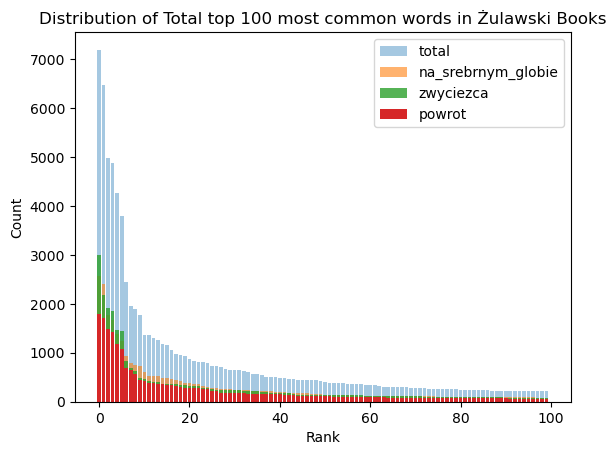

In [8]:

books_with_labels = list(zip(
    ["na_srebrnym_globie", "powrot", "zwyciezca", 'total'],
    df_list_of_lemmas
))

sorted_books = sorted(books_with_labels, key=lambda x: x[1]['count'].sum(), reverse=True)

alpha = 0.4
plt.figure()
for label, book in sorted_books:
    total_words = book.head(100)
    plt.bar(range(len(total_words)), total_words['count'], label = label, alpha = alpha)
    plt.title("Distribution of Total top 100 most common words in Żulawski Books")
    plt.xlabel("Rank")
    plt.ylabel("Count")
    plt.legend()
    alpha += 0.2   
plt.show()


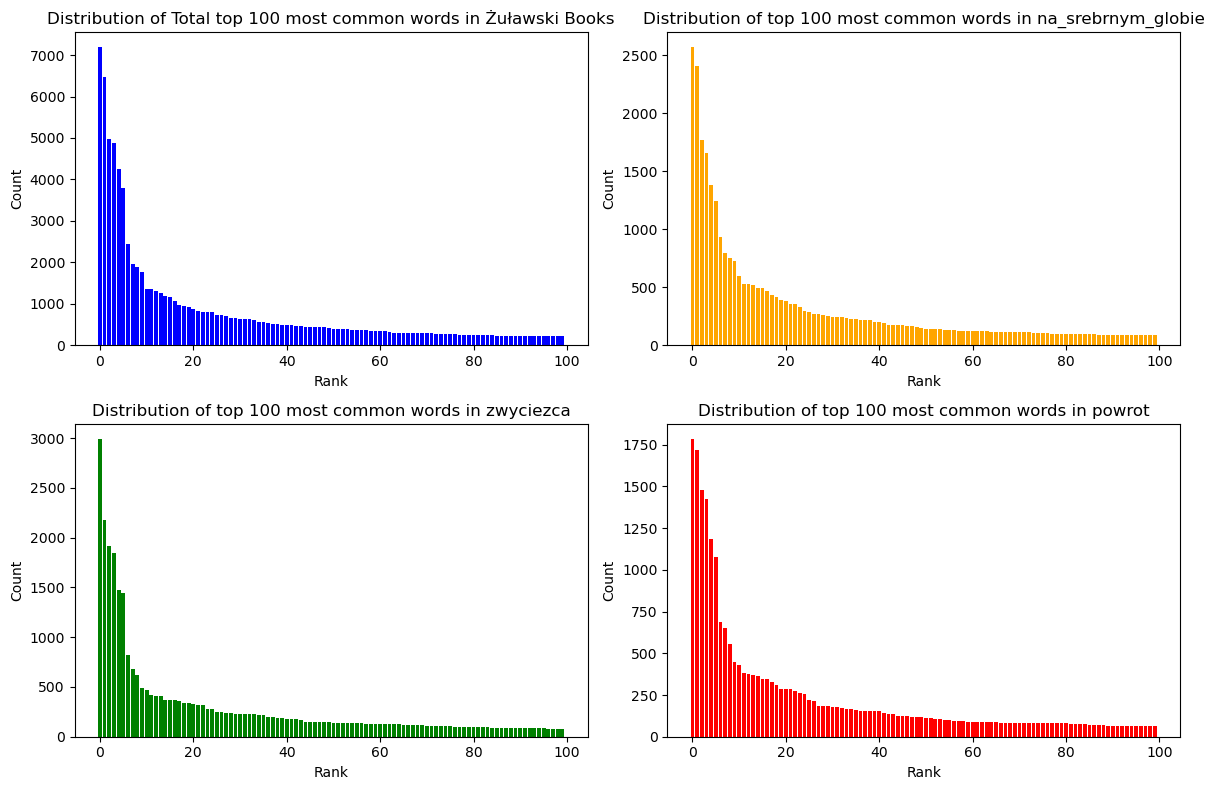

In [9]:
colors = ['blue', 'orange', 'green', 'red']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
color = 0 
for ax, (label, book) in zip(axes, sorted_books):
    total_lemmas = book.head(100)
    ax.bar(range(len(total_lemmas)), total_lemmas['count'], color = colors[color])
    if label != "total":
        ax.set_title(f"Distribution of top 100 most common words in {label}")
    else:
        ax.set_title("Distribution of Total top 100 most common words in Żuławski Books")
    ax.set_xlabel("Rank")
    ax.set_ylabel("Count")
    color +=1
plt.tight_layout()
plt.show()

# Zipf Law and curve fitting

According to Zipf law when a set of measured values is sorted in decreasing order of frequencies, the word frequency is inversely proportional to it's statistical rank (position in sorted list). Formally we can write: </br>
</br>
</br>
$word frequency \propto \frac{1}{word rank} $

</br>
</br>
or in alternative form: </br>
</br>
</br>

$x(k) = \frac{x_M}{k}$, where k is a rank, and $x_m$ is the maximum size in a set of N objects.

</br>
</br>
</br>
Or sometimes in so called Mandelbrot modified form: 
</br>
</br>

$ f = \frac{k}{(r+\alpha)^\beta} $


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 9.492e+05
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:06:20   Log-Likelihood:                 9313.6
No. Observations:               35888   AIC:                        -1.862e+04
Df Residuals:                   35886   BIC:                        -1.861e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5704      0.009   -273.175      0.0

/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_13866/4284282896.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_13866/4284282896.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


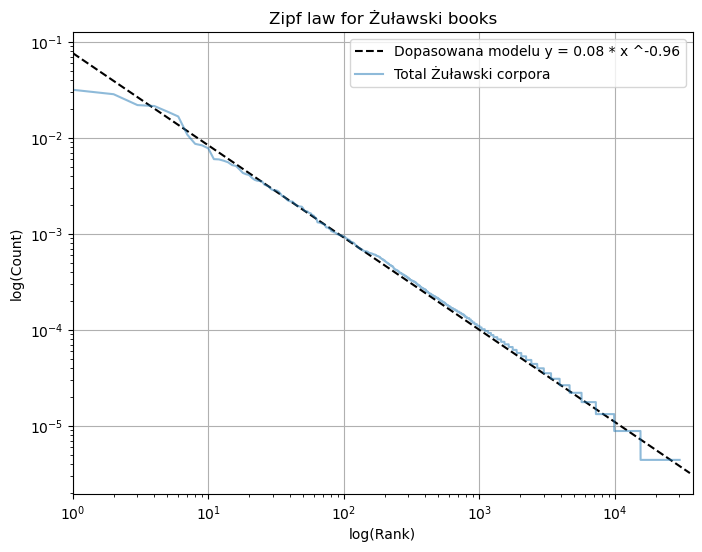

In [10]:
N = sorted_books[0][1]['count'].sum()
n = len(sorted_books[0][1])
x = np.log(np.arange(1, n, 1))
X = sm.add_constant(x)
top_n = sorted_books[0][1].head(n - 1)
y = np.log(top_n['count'] / N)
results = sm.OLS(y, X).fit()
print(results.summary())

b = results.params[1]
a = np.exp(results.params[0])

def func(a, b, x):
    return a * np.power(x, b)

args = np.arange(1, n - 1, 1)
vals = func(a, b, args)


plt.figure(figsize = (8, 6))
plt.plot(args, vals, linestyle = "--", color = 'black', label = f'Dopasowana modelu y = {round(a,2)} * x ^{round(b,2)}')

n_counted_books = sorted_books[0][1].head(30115 - 1) #because we are starting for 0, since log0 is not defined
rank = np.arange(1, len(n_counted_books['count']) + 1)
plt.plot(rank, n_counted_books['count'] / N, label="Total Żuławski corpora", alpha=0.5)
plt.title("Zipf law for Żuławski books")
plt.xlabel("log(Rank)")
plt.xlim(left = 1)
plt.ylabel("log(Count)")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend() 
plt.show()

As we can see on the log - log plot the frequencies of words from corpora of three Żuławski books is distributed according to Zipf Law. 
</br>
</br>
</br>

The fitted curve is $\frac{6170.57}{x^{0.88}}$. 
</br>
</br>
As we can see the power parameter ($\beta$ in Mandelbrot form) is approximately lowe than 1 ($\beta = 0.88$). The fitted curve explains variance very well, because $R^2 = 0.949$
</br>
</br>
On the next plot I compared 3 books with total coropora (added tokens from 3 Witkacy books). This time I also normalized scale on y - axis. The parameters of the model were normalized as well.

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 9.492e+05
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:06:21   Log-Likelihood:                 9313.6
No. Observations:               35888   AIC:                        -1.862e+04
Df Residuals:                   35886   BIC:                        -1.861e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5704      0.009   -273.175      0.0

/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_13866/4053241880.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_13866/4053241880.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


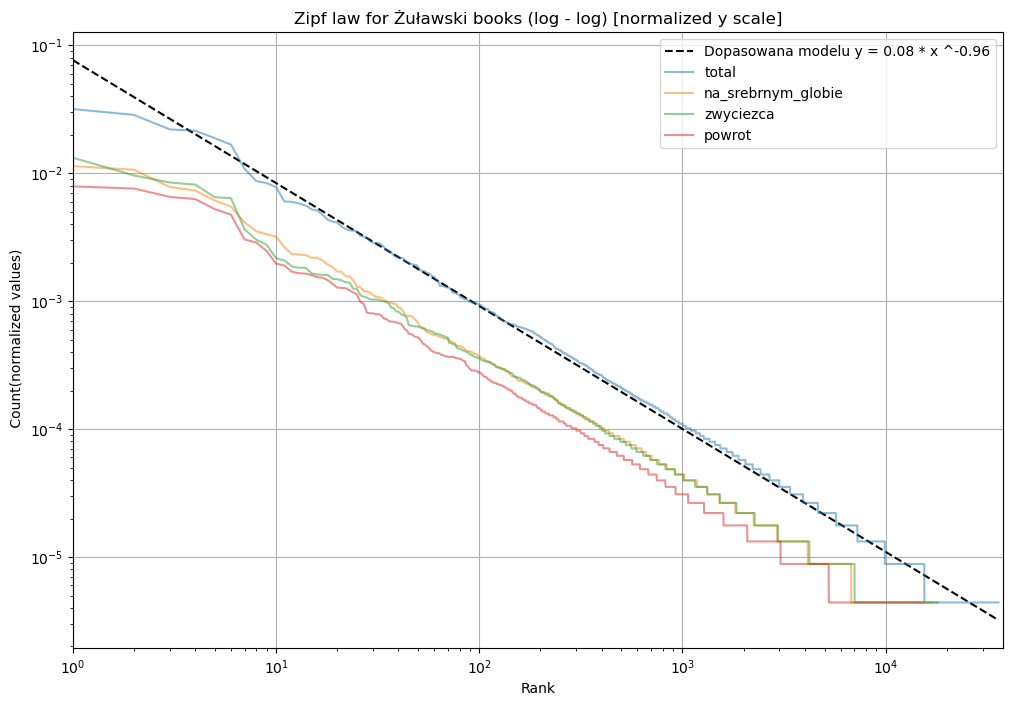

In [11]:
N = sorted_books[0][1]['count'].sum()
n = len(sorted_books[0][1])
x = np.log(np.arange(1, n, 1))
X = sm.add_constant(x)
total_lemmas = sorted_books[0][1].head(n -  1)
y = np.log(total_lemmas['count']/ N)
results = sm.OLS(y, X).fit()
print(results.summary())
b = results.params[1]
a = np.exp(results.params[0])

def func(a, b, x):
    return a * np.power(x, b)

args = np.arange(1, n, 1)
vals = func(a, b, args)


plt.figure(figsize = (12, 8))
plt.plot(args, vals, linestyle = "--", color = 'black', label = f'Dopasowana modelu y = {round(a,2)} * x ^{round(b,2)}')
for label, book in sorted_books:
    n_counted_books = book.head(n - 1) #because we are starting for 0, since log0 is not defined
    normalized_counted_books = n_counted_books['count'] /  N
    rank = np.arange(1, len(n_counted_books) + 1)
    plt.plot(rank, normalized_counted_books.values, label=label, alpha=0.5)
    if label != "total":
        plt.title("Zipf law for Żuławski books (log - log) [normalized y scale]")
    else:
        plt.title("Zipf law for Żuławski books")
    plt.xlabel("Rank")
    plt.xlim(left = 1)
    plt.ylabel(" Count(normalized values)")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.legend() 
plt.show()

# Heaps - Herdan Law 

The next investigated linguistic empirical law was Heaps - Herdan law. This law states that as the length of the text (measured in tokens) increases, the number of elements in the dictionary (number of types) grows more slowly. This is intuitive, because as the length of the corpora increases, it becomes less likely to find new words that have not appeared before

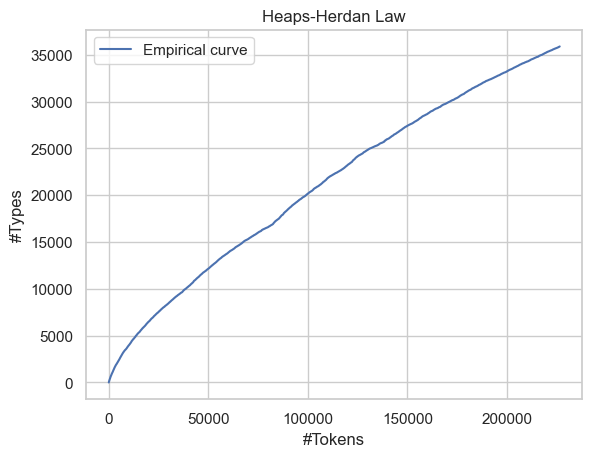

In [12]:
tokenized_texts = df['tokenized_text']
total_corpus = []
length = len(tokenized_texts)
for i in range((length)):
    total_corpus += tokenized_texts[i]
tokens = 0
types = 0

Tokens = []
Types = []


types_set = set()
for i in total_corpus:
    types_set.add(i)
    types = len(types_set)
    tokens += 1
    Tokens.append(tokens)
    Types.append(types)

sns.set_theme(style = 'whitegrid')
g = sns.lineplot(x = Tokens, y = Types, label = 'Empirical curve')
plt.title("Heaps-Herdan Law")
plt.xlabel("#Tokens")
plt.ylabel('#Types')
plt.show()




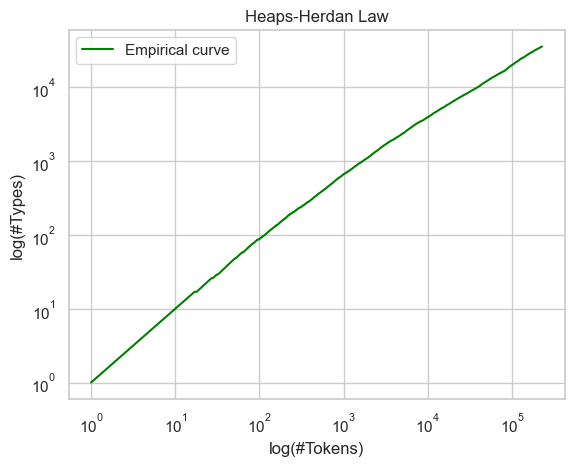

In [13]:
sns.set_theme(style = 'whitegrid')
g = sns.lineplot(x = Tokens, y = Types, label = 'Empirical curve', color = "green")
plt.title("Heaps-Herdan Law")
plt.xlabel("log(#Tokens)")
plt.ylabel('log(#Types)')
plt.xscale('log')
plt.yscale('log')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.863e+08
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:06:22   Log-Likelihood:             5.1141e+05
No. Observations:              226552   AIC:                        -1.023e+06
Df Residuals:                  226550   BIC:                        -1.023e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5546      0.001   2569.020      0.0

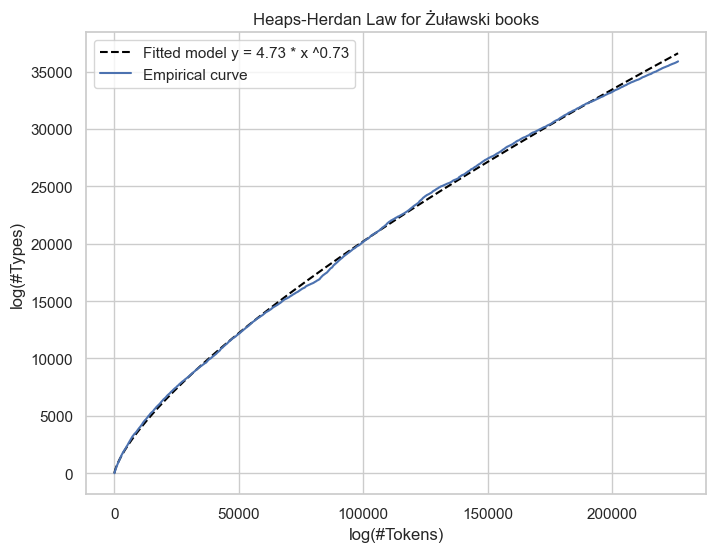

In [14]:
v = np.log(np.arange(1, len(Tokens)+1, 1))
len_t = len(Tokens)
V = sm.add_constant(v)
top_types = np.log(np.array(Types))
u = top_types
results = sm.OLS(u, V).fit()
print(results.summary())
b = results.params[1]
a = np.exp(results.params[0])

def func(a, b, x):
    return a * (x ** b)

args = np.arange(1, len_t, 1)
vals = func(a, b, args)


plt.figure(figsize = (8, 6))
plt.plot(args, vals, linestyle = "--", color = 'black', label = f'Fitted model y = {round(a,2)} * x ^{round(b,2)}')
plt.plot(Tokens, Types, label = "Empirical curve")
plt.legend()
plt.title("Heaps-Herdan Law for Żuławski books")
plt.xlabel("log(#Tokens)")
plt.ylabel('log(#Types)')
plt.show()

# Excercise 2

The next part of the project focused on investigating Zipf and Heaps-Herdan law with lemmatize text. 

In [15]:
def XML_PARSER_WITH_LEMMA_EXTRACTION(file_path):
    with open(file_path, 'r') as f:
        xml_file = f.read()
    bs_data = BeautifulSoup(xml_file, 'xml')
    lemmas = [w["lemma"].lower() for w in bs_data.find_all("w")]
    return lemmas
    

In [16]:
sienkiewicz_o_i_m_xml = 'POL0097_zulawski_na-srebrnym-globie-2.xml'
powrot_xml_lvl2 = 'POL0098_zulawski_powrot-2.xml' 
zwyciezca_xml_lvl2 = 'POL0099_zulawski_zwyciezca-2.xml'

XML_FILES = [sienkiewicz_o_i_m_xml, powrot_xml_lvl2, zwyciezca_xml_lvl2]

titles = ["na_srebrnym_globie", "powrot", "zwyciezca"]

FULL_TEXTS = [] 

data = {"title" : [], "text": []}

for file in XML_FILES:
    full_text = XML_PARSER_WITH_LEMMA_EXTRACTION(file)
    FULL_TEXTS.append(full_text)

for i in range(len(FULL_TEXTS)):
    data['text'].append(FULL_TEXTS[i])
    data['title'].append(titles[i])

df_lvl2 = pd.DataFrame(data=data)


    

In [17]:
number_of_books = len(df_lvl2['title'])
counted_lemmas = []
ile = 0
#creating list of dictionaries with diffrent books of Witkacy
for i in range(number_of_books):
    book = df_lvl2['text'][i]
    counted_book = Counter(book)
    counted_lemmas.append(counted_book)

#creating dictionary from total words from all 3 books. 
total_lemmas_from_zulawski_books = {i: counted_lemmas[0].get(i, 0) + counted_lemmas[1].get(i, 0) + counted_lemmas[2].get(i, 0)
                                   for i in set(counted_lemmas[0]).union(counted_lemmas[1]).union(counted_lemmas[2])}
counted_lemmas.append(total_lemmas_from_zulawski_books)

n = len(counted_lemmas)
df_list_of_lemmas = []
for i in range(n):
    lemmas_data = pd.DataFrame(counted_lemmas[i].items(), columns=['word', 'count'])
    lemmas_data = lemmas_data.sort_values(by='count', ascending=False).reset_index(drop = True)
    df_list_of_lemmas.append(lemmas_data)

books_with_labels_lemmas = list(zip(
    ['na_srebrnym_globie', 'powrot', 'zwyciezca', 'total'],
    df_list_of_lemmas
))


Before ploting line plot. Let's take a look briefly on bar plots comparing total Witkacy Corpus with and without lemmatization:

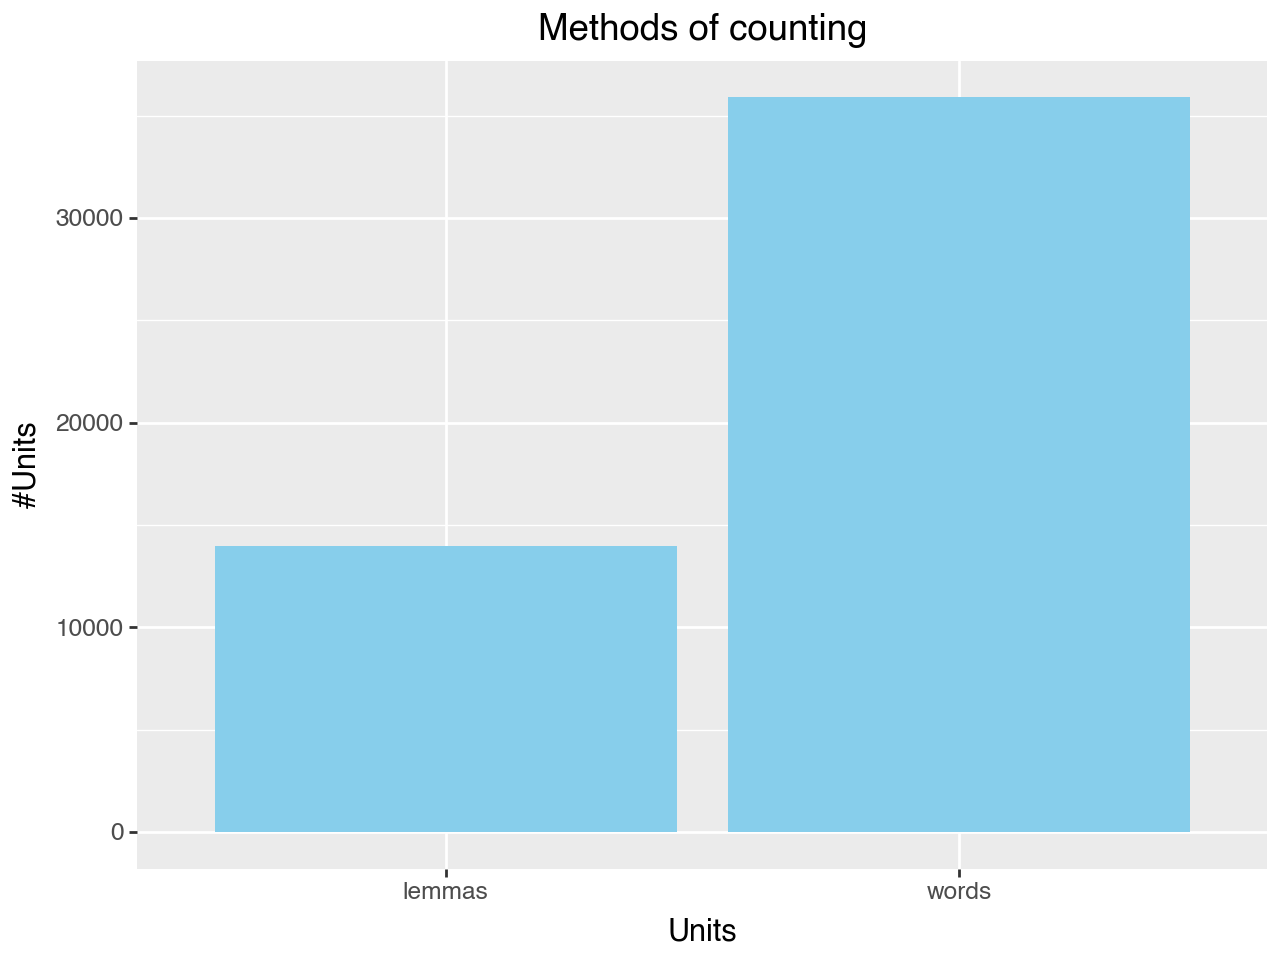

In [18]:

total_lemmas = len(books_with_labels_lemmas[3][1])
total_words = len(sorted_books[0][1]['count'])
corpus = pd.DataFrame({'labels': ['words', 'lemmas'], 'n': [total_words, total_lemmas]})


(ggplot(corpus, aes(x='labels', y='n'))
 + geom_bar(stat='identity', fill='skyblue')
 + labs(title='Methods of counting', x='Units', y='#Units'))




As we can see, there are more words than lemmas. So we need to check the Zipf's law and Heaps-Herdan's law for lemmatized corpus.

In [19]:
total_lemmas = books_with_labels_lemmas[3][1]

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 5.416e+05
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:06:26   Log-Likelihood:                 2675.8
No. Observations:               13984   AIC:                            -5348.
Df Residuals:                   13982   BIC:                            -5333.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6862      0.015    -47.103      0.0

/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_13866/1545714728.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_13866/1545714728.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


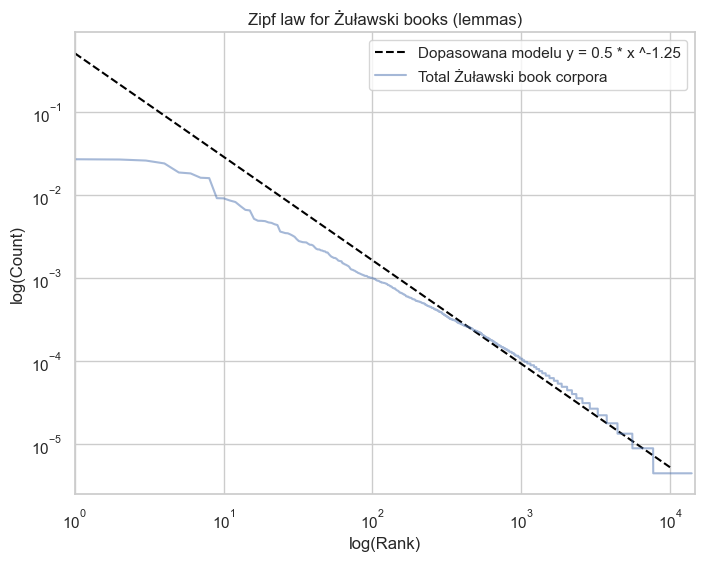

In [20]:
len_lemma = len(total_lemmas['count'])
x = np.log(np.arange(1, len_lemma + 1, 1))
X = sm.add_constant(x)

y = np.log(total_lemmas['count'] / N)
results = sm.OLS(y, X).fit()
print(results.summary())

b = results.params[1]
a = np.exp(results.params[0])

def func(a, b, x):
    return a * np.power(x, b)

args = np.arange(1, 10000, 1)
vals = func(a, b, args)


plt.figure(figsize = (8, 6))
plt.plot(args, vals, linestyle = "--", color = 'black', label = f'Dopasowana modelu y = {round(a,2)} * x ^{round(b,2)}')

rank = np.arange(1, len_lemma + 1)
plt.plot(rank, total_lemmas['count'] / N, label="Total Żuławski book corpora", alpha=0.5)
plt.title("Zipf law for Żuławski books (lemmas)")
plt.xlabel("log(Rank)")
plt.xlim(left = 1)
plt.ylabel("log(Count)")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend() 
plt.show()

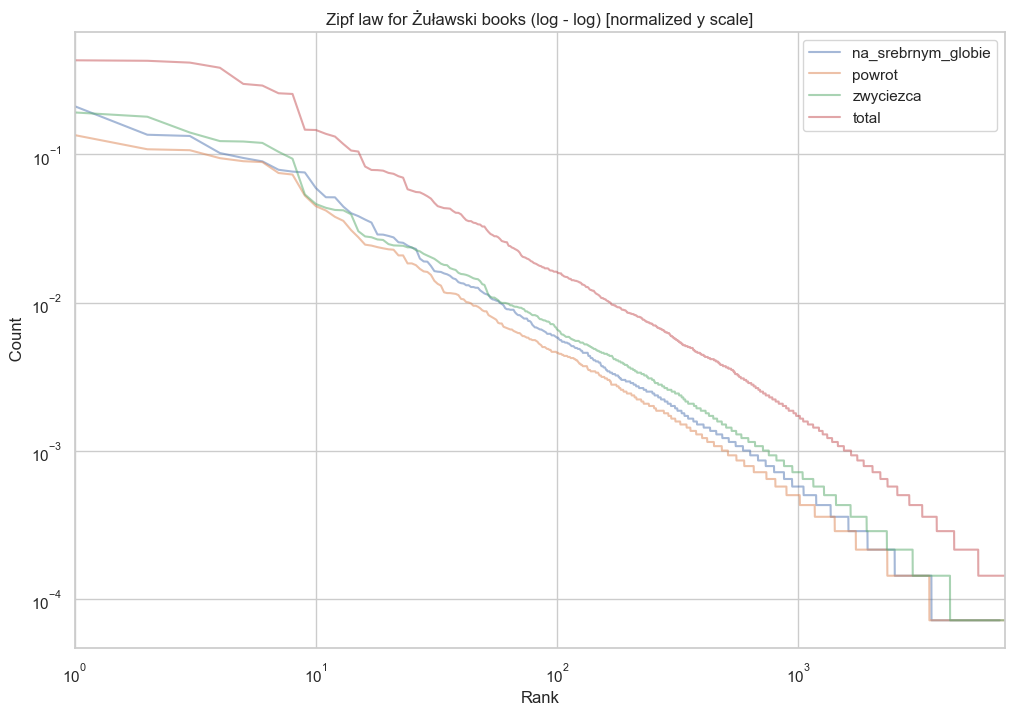

In [21]:
n = len(books_with_labels_lemmas[i][1])

plt.figure(figsize = (12, 8))
for label, book in books_with_labels_lemmas:
    n_counted_books = book.head(n - 1) #because we are starting for 0, since log0 is not defined
    normalized_counted_books = n_counted_books['count'] /  n
    rank = np.arange(1, len(n_counted_books) + 1)
    plt.plot(rank, normalized_counted_books.values, label=label, alpha=0.5)
    if label != "total":
        plt.title("Zipf law for Żuławski books (log - log) [normalized y scale]")
    else:
        plt.title("Zipf law for Żuławski books (log - log) [normalized y scale]")
    plt.xlabel("Rank")
    plt.xlim(left = 1)
    plt.ylabel(" Count")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.legend() 
plt.show()

Now let's see how Heaps-Herdan law works on a corpus composed of lemmas. 

In [22]:
def counting_HH_law(corpus): 
    tokens = 0
    types = 0

    Tokens = []
    Types = []

    types_set = set()
    for i in total_corpus:
        types_set.add(i)
        types = len(types_set)
        tokens += 1
        Tokens.append(tokens)
        Types.append(types)
    return Tokens, Types



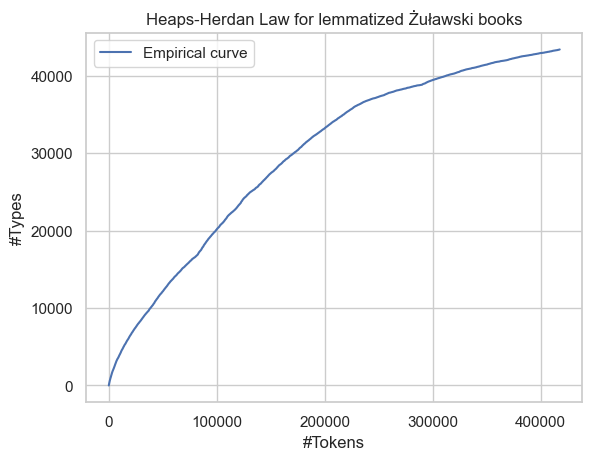

In [23]:
length = len(FULL_TEXTS)

for i in range((length)):
    total_corpus += FULL_TEXTS[i]
tokens = 0
types = 0

Tokens = []
Types = []


types_set = set()
Tokens, Types = counting_HH_law(total_corpus)

sns.set_theme(style = 'whitegrid')
g = sns.lineplot(x = Tokens, y = Types, label = 'Empirical curve')
plt.title("Heaps-Herdan Law for lemmatized Żuławski books")
plt.xlabel("#Tokens")
plt.ylabel('#Types')
plt.show()


# EXERCISE 3
Check the different parts of speech for one long text.

In [24]:
def XML_PARSER_WITH_PART_OF_SPEECH_EXTRACTION(file_path, part_of_speech: str):
    with open(file_path, 'r') as f:
        xml_file = f.read()
    bs_data = BeautifulSoup(xml_file, 'xml')
    lemmas = [w.get_text().lower() for w in bs_data.find_all("w") if w.get("pos") == part_of_speech]
    return lemmas

In [25]:
sienkiewicz_o_i_m_xml = 'POL0070_sienkiewicz_ogniem-i-mieczem.xml'

rzeczowniki_sienkiewicz_o_i_m = XML_PARSER_WITH_PART_OF_SPEECH_EXTRACTION(sienkiewicz_o_i_m_xml, "NOUN")
czasowniki_sienkiewicz_o_i_m = XML_PARSER_WITH_PART_OF_SPEECH_EXTRACTION(sienkiewicz_o_i_m_xml, "VERB")
przymiotniki_sienkiewicz_o_i_m = XML_PARSER_WITH_PART_OF_SPEECH_EXTRACTION(sienkiewicz_o_i_m_xml, "ADJ")
spojniki_sienkiewicz_o_i_m = XML_PARSER_WITH_PART_OF_SPEECH_EXTRACTION(sienkiewicz_o_i_m_xml, "CCONJ")